# Intoduction
* **Gray-wolf optimizer is a new evolutionary computation technique which mimics the leadership hierarchy and hunting mechanism of gray wolves in nature.**
* **The aim of the gray wolf optimization is find optimal regions of the complex search space through the interaction of individuals in the population.**
* **Compared to PSO(particle swarm optimization) and GA(Genetic Algo) this gives better results with UCI machine learning data repository e.g UCI Breast Cancer dataset.**
* **This proves better performance in both classification accuracy and feature size reduction.**
* **And GWO is much more robust than GA & PSO.**

**Just click here to instantly move to that place**<br>
* [Utils](#utils)
* [Data Preparation](#dataPreparation)
* [Gray Wolf Optimization](#GWO)
    - [Feature Extraction](#FE)
    - [Data Preparation](#DP)
    - [Classification](#classification)
* [Genetic Algorithm](#GA)
    - [Classification](#GC)
* [Particle Swarm Optimizatioin](#PSO)
    - [Classification](#PC)
* [Hybrid GWO JAYA](#HGJ)
    - [Classification](#HC)


# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installs

In [ ]:
# If these packages are not installed on your python env then install them by uncommenting them.
!pip install zoofs
# !pip install sklearn-genetic
!pip install niapy --pre
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from niapy.problems import Problem
from niapy.task import Task
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from niapy.algorithms.basic import ParticleSwarmOptimization
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# from genetic_selection import GeneticSelectionCV
sc = StandardScaler()

<a name='utils'></a>
# Utils

In [ ]:
# To evaluate model performance

def evaluate_fn(Y_test,model_pred):
    # cm = confusion_matrix(Y_test.argmax(), model_pred.argmax())
    cm = confusion_matrix(Y_test.astype(int).tolist(), model_pred)

    True_Positives = cm[0][0]
    False_Positives = cm[0][1]

    True_Negetives = cm[1][1]
    False_Negetives = cm[1][0]

    # return True_Positives,False_Positives,False_Negetives,True_Negetives

    precision =  True_Positives / (True_Positives + False_Positives)
    recall = True_Positives / (True_Positives + False_Negetives)
    f1_score = 2*(precision * recall) / (precision + recall)

    return precision,recall,f1_score
# here X is features and y is labels
# k is the num_ of splits usally k = 3, k =5, or k = 10
def kfold(k, model, X, y):

  # prepare the cross-validation procedure
  cv = KFold(n_splits=k, random_state=1, shuffle=True)  # 10-fold cross-validation
  # evaluate model
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report performance
  acc = mean(scores)

  return acc, scores.min(), scores.max()

# K-fold cross validation

def k_evaluate(k,model,x , y):
  acc_list = {}
  for i in range(2, k+1):
    acc,_,_ = kfold(i, model, x, y)
    acc_list.update( {i : acc} )
    print(f"for fold: {i}, accuracy is: {acc_list.get(i)}")
  # get max
  m_key = max(acc_list, key = acc_list.get)
  print("Best fit")
  print(f"{m_key} gives accuracy of {acc_list.get(m_key)}")
  return acc_list.get(m_key) # acc

<a name='dataPreparation'></a>
# Data Preparation

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Work Space/cns.csv")
data.head()

,samples,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V6025,V6026,V6027,V6028,V6029,V6030,V6031,V6032,V6033,response
0,1,-0.927178,-0.740039,-0.532016,-1.097891,-0.986673,0.018752,-0.863326,3.959997,-0.398219,...,-1.097891,-1.097891,-0.894733,0.850270,-1.097891,-0.302063,-0.767685,-0.452616,0.194001,normal
1,2,-0.835899,-0.835899,-0.585647,-0.835899,-0.329768,-0.835899,-0.835899,4.037788,-0.835899,...,-0.835899,-0.835899,-0.835899,0.038090,-0.835899,-0.835899,-0.835899,-0.835899,0.075500,normal
2,3,0.236073,0.252645,-1.154351,-0.372372,-0.338900,1.253467,0.506325,3.868961,0.201932,...,-1.154351,-1.154351,-0.372372,0.899781,-0.867200,0.360426,-1.154351,-1.154351,-1.154351,normal
3,4,-0.748623,-0.439165,0.790953,-1.033876,0.241115,1.216007,0.106282,3.976272,0.081755,...,-1.121534,-1.121534,-0.812076,1.230378,-0.355497,0.030647,-0.278810,-1.121534,-1.121534,normal
4,5,0.101239,-0.298285,-1.121519,-0.957714,0.342258,1.182937,0.029325,4.575871,-0.196466,...,-1.121519,-1.121519,-0.454932,0.891627,-0.593427,0.306316,-0.076496,-0.134480,-1.121519,normal


In [ ]:
data.columns

Index(['samples', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       ...
       'V6025', 'V6026', 'V6027', 'V6028', 'V6029', 'V6030', 'V6031', 'V6032',
       'V6033', 'response'],
      dtype='object', length=6035)

In [ ]:
# Drop column samples
data.drop(["samples"], axis = 1, inplace=True)
# Now shuffle it
data = data.sample(frac = 1)

In [ ]:
data["response"].unique()

array(['tumer', 'normal'], dtype=object)

In [ ]:
print("Lenght of Dataset:", len(data))
print("Num of columns:", len(data.columns))

Lenght of Dataset: 102
Num of columns: 6034


In [ ]:
# class values are in byte string format but we need them in integer format
# Converting them into string first
y = data.response  # label
# len(y)
# y[0]
def cvt(str):
  return str.decode("utf-8")

for st in range(len(y)):
  y[st] = y[st]
# print(y)

<ipython-input-10-afc1346df41b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[st] = y[st]


In [ ]:
# Then convert them into integer
y.replace({"normal": 0, "tumer": 1}, inplace= True)
# convert label type to float
y = y.astype(float)

In [ ]:
# grab our features
x = data.drop(['response'], axis=1)
# Fetch list of columns
cols = (data.columns).to_list()
len(cols)

6034

In [ ]:
# convert numpy array to dictionary
col_dict = dict(enumerate((x.columns.to_numpy()).flatten(), 0))
len(col_dict)

6033

## Train Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

x_train shape:  (81, 6033)
y_train shape:  (81,)
x_text:  (21, 6033)
y_test:  (21,)


In [ ]:
# Data scalling
# sc = StandardScaler()
# X_train = sc.fit_transform(x_train)
# X_test = sc.transform(x_test)

In [ ]:
type(x_train)  # make sure x_train should be in pandas.core.frame.DataFrame format

pandas.core.frame.DataFrame

<a name=GWO></a>
# GWO(Grey Wolf Optimization)

<a name=FE></a>
## Extracting Features

In [ ]:
from zoofs import GreyWolfOptimization

In [ ]:
# Set up objective function
from sklearn.metrics import log_loss
# make sure that objective fun shoud recieve 4 parameters
# Now fit your model to return objective vaule
def objective_function(model,X_train, y_train, X_valid, y_valid):
    model.fit(X_train,y_train)
    P=log_loss(y_valid,model.predict_proba(X_valid))
    return P


In [ ]:
# create object of algorithm
# population_size=? change this number if you want more features depending open your computation power
algo_object=GreyWolfOptimization(objective_function,n_iteration=10,
                                    population_size=100,minimize=True)

In [ ]:
# !pip install lightgbm

In [ ]:
# Import and initialize classifier
# import lightgbm as lgb
lgb_model = LinearDiscriminantAnalysis()

# Fit the classifier
features = algo_object.fit(lgb_model,x_train, y_train, x_test, y_test,verbose=True)

 [ 2023-02-17 14:04:42,228 ] Finished iteration #0 with objective value 0.23593519480665326. Current best value is 0.23593519480665326 
 [ 2023-02-17 14:05:13,925 ] Finished iteration #1 with objective value 0.2398758537652787. Current best value is 0.23593519480665326 
 [ 2023-02-17 14:05:47,562 ] Finished iteration #2 with objective value 0.23649645608292613. Current best value is 0.23593519480665326 
 [ 2023-02-17 14:06:27,466 ] Finished iteration #3 with objective value 0.2352478500740301. Current best value is 0.2352478500740301 
 [ 2023-02-17 14:07:02,727 ] Finished iteration #4 with objective value 0.2473169863467661. Current best value is 0.2352478500740301 
 [ 2023-02-17 14:07:41,629 ] Finished iteration #5 with objective value 0.2467571622727993. Current best value is 0.2352478500740301 
 [ 2023-02-17 14:08:19,203 ] Finished iteration #6 with objective value 0.2514191403810528. Current best value is 0.2352478500740301 
 [ 2023-02-17 14:08:56,443 ] Finished iteration #7 with o

In [ ]:
len(features)

5213

In [ ]:
# Now plot the result
algo_object.plot_history()

<a name=DP></a>
## Data Preparation

In [ ]:
# Fetching our new dataset with selected features
new_data = data[features]
new_data.head()

,V1,V2,V4,V5,V6,V7,V8,V9,V10,V11,...,V6022,V6024,V6025,V6026,V6027,V6028,V6029,V6031,V6032,V6033
66,-0.436655,-0.880366,-1.056411,0.478109,-1.056411,-0.340017,4.287616,-0.436655,-1.056411,0.153221,...,-0.803080,0.624133,-1.056411,-1.056411,-0.133796,0.986985,-0.602589,-0.880366,0.458200,-0.664905
35,-0.925287,-0.925287,-0.925287,-0.925287,-0.667220,-0.925287,4.845647,-0.925287,-0.925287,0.334666,...,-0.347128,-0.195502,-0.925287,-0.925287,-0.243493,0.438300,-0.925287,-0.745952,-0.106021,0.087468
77,-0.838671,-0.838671,-0.838671,-0.662620,-0.662620,-0.838671,4.298436,-0.838671,-0.838671,0.938577,...,-0.838671,0.046106,-0.838671,-0.838671,-0.838671,0.189422,1.250250,-0.838671,-0.838671,0.083978
11,-0.277425,-0.660388,-1.014288,0.720023,0.228375,-0.066664,3.813493,-0.549142,-1.104309,0.156606,...,0.023357,0.078932,-1.104309,-1.104309,-0.932106,1.089198,-0.856505,-0.603128,-1.014288,-0.066664
91,-0.714321,-1.206937,-1.206937,0.374589,1.106187,0.335601,3.837362,0.662006,-1.206937,-0.232117,...,0.755697,1.090121,-1.206937,-1.206937,-0.714321,1.523627,-1.206937,-1.206937,-1.206937,-0.924944


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_data, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_train shape:  (81, 5213)
y_train shape:  (81,)


In [ ]:
# Data scalling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input

In [ ]:
# Model

data = Input((x_train.shape[1],1),dtype= 'float32')

X = LSTM(128,return_sequences =True)(data)
X = Dropout(0.5)(X)
X = LSTM(64,return_sequences = True)(X)
X = Dropout(0.5)(X)
X = LSTM(32,return_sequences = False)(X)
X = Dropout(0.2)(X)
X = Dense(units=4)(X)
X = Dense(units=2)(X)
# use sigmoid
X = Activation('sigmoid')(X)   # sigmoid is for binary classification and softmax for multiclass classification.
lstm = Model(data, X)

In [ ]:
lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4538, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, 4538, 128)         66560     
                                                                 
 dropout (Dropout)           (None, 4538, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 4538, 64)          49408     
                                                                 
 dropout_1 (Dropout)         (None, 4538, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [ ]:
lstm.compile(optimizer= Adam(learning_rate= 0.0001), loss= 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
# fun for converting our target to one_hot vectior format.
def convert_to_one_hot(Y, C):  # Y - target column and C- is the number of classes(here its is 2).
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
Y_train = y_train.to_numpy() # Y_train is series here so we converted into numpy array
Y_train_oh = convert_to_one_hot(Y_train.astype(int),2)  # one_hot vec format
type(Y_train)

numpy.ndarray

In [ ]:
print(x_train.shape)
print(Y_train_oh.shape)

(81, 4538)
(81, 2)


In [ ]:
hist = lstm.fit(x_train, Y_train_oh, epochs= 300, batch_size = 5, shuffle=True, verbose = 2)

Epoch 1/300
17/17 - 16s - loss: 0.6921 - accuracy: 0.5062 - 16s/epoch - 953ms/step
Epoch 2/300
17/17 - 4s - loss: 0.6911 - accuracy: 0.5556 - 4s/epoch - 258ms/step
Epoch 3/300
17/17 - 6s - loss: 0.6869 - accuracy: 0.5432 - 6s/epoch - 327ms/step
Epoch 4/300
17/17 - 7s - loss: 0.6849 - accuracy: 0.5432 - 7s/epoch - 388ms/step
Epoch 5/300
17/17 - 7s - loss: 0.6841 - accuracy: 0.5309 - 7s/epoch - 400ms/step
Epoch 6/300
17/17 - 6s - loss: 0.6764 - accuracy: 0.5679 - 6s/epoch - 338ms/step
Epoch 7/300
17/17 - 6s - loss: 0.6741 - accuracy: 0.5679 - 6s/epoch - 352ms/step
Epoch 8/300
17/17 - 6s - loss: 0.6791 - accuracy: 0.5679 - 6s/epoch - 349ms/step
Epoch 9/300
17/17 - 5s - loss: 0.6708 - accuracy: 0.5679 - 5s/epoch - 282ms/step
Epoch 10/300
17/17 - 4s - loss: 0.6653 - accuracy: 0.5802 - 4s/epoch - 252ms/step
Epoch 11/300
17/17 - 5s - loss: 0.6676 - accuracy: 0.5802 - 5s/epoch - 295ms/step
Epoch 12/300
17/17 - 6s - loss: 0.6620 - accuracy: 0.5802 - 6s/epoch - 347ms/step
Epoch 13/300
17/17 - 6s

In [ ]:
# Y_test_oh = tf.one_hot(y_test.to_numpy(), 2)
Y_test_oh = convert_to_one_hot((y_test.to_numpy()).astype(int),2)

In [ ]:
lstm.evaluate(x_test,Y_test_oh,batch_size=5)

5/5 [==============================] - 2s 163ms/step - loss: 0.9863 - accuracy: 0.7619


[0.9862530827522278, 0.761904776096344]

In [ ]:
lstm.save("Gwo&Jaya_lstm.h5")

<a name=PSO></a>
# PSO(Particle Swarm Optimization)

In [ ]:
class SVMFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVC(), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
feature_names = x.columns
feature_names

x_train shape:  (455, 30)
y_train shape:  (455,)


Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
problem = SVMFeatureSelection(X_train, y_train)
task = Task(problem, max_iters=100)
algorithm = ParticleSwarmOptimization(population_size=10, seed=101)
best_features, best_fitness = algorithm.run(task)

In [ ]:
selected_features = best_features > 0.5
print('Number of selected features:', selected_features.sum())
print('Selected features:', ', '.join(feature_names[selected_features].tolist()))

Number of selected features: 10
Selected features: radius_mean, smoothness_mean, concavity_mean, area_se, compactness_se, concavity_se, concave points_se, texture_worst, perimeter_worst, concave points_worst


<AxesSubplot: >

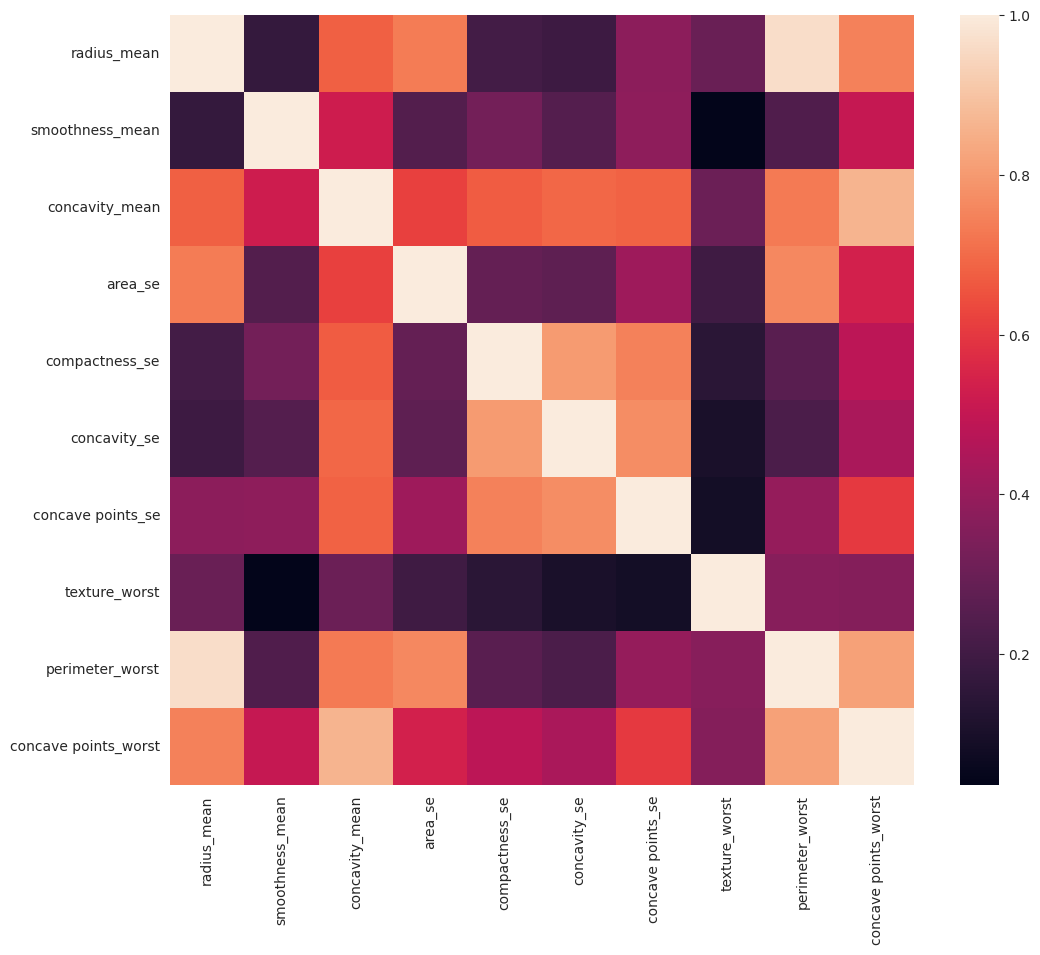

In [ ]:
# Co-relation matrix
new_x = data[feature_names[selected_features]]
cor = new_x.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor)

<a name=PC></a>
## Classification

## SVC

Model accuracy: 0.9736842105263158
[[72  0]
 [ 3 39]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



/home/shadowdude/dude/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



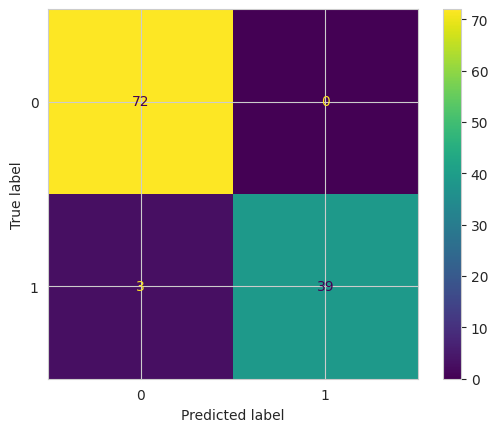

In [ ]:
model = SVC()
X_train = sc.fit_transform(X_train[:, selected_features])
X_test = sc.transform(X_test[:, selected_features])
model.fit(X_train, y_train)
print('Model accuracy:', model.score(X_test, y_test))

# plot confusion matrix
model_pred = model.predict(X_test)
print(confusion_matrix(y_test,model_pred))
print('\n')
print(classification_report(y_test,model_pred))
plot_confusion_matrix(model, X_test, y_test)


In [ ]:
# Calculate all
model_pred = model.predict(X_test)
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
#K-fold
acc = k_evaluate(10,model, x[feature_names[selected_features]], y)  # here k 10

precision :  1.0 
 recall : 0.96 
 f1_score : 0.9795918367346939


for fold: 2, accuracy is: 0.9261860637509266
for fold: 3, accuracy is: 0.9297131718184349
for fold: 4, accuracy is: 0.9297128927410617
for fold: 5, accuracy is: 0.9279925477410339
for fold: 6, accuracy is: 0.9332586786114221
for fold: 7, accuracy is: 0.9367445261754205
for fold: 8, accuracy is: 0.9332208528951487
for fold: 9, accuracy is: 0.9332837301587301
for fold: 10, accuracy is: 0.9349937343358397
Best fit
7 gives accuracy of 0.9367445261754205


### LDA

Subset accuracy: 0.956140350877193
[[72  0]
 [ 5 37]]


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



/home/shadowdude/dude/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



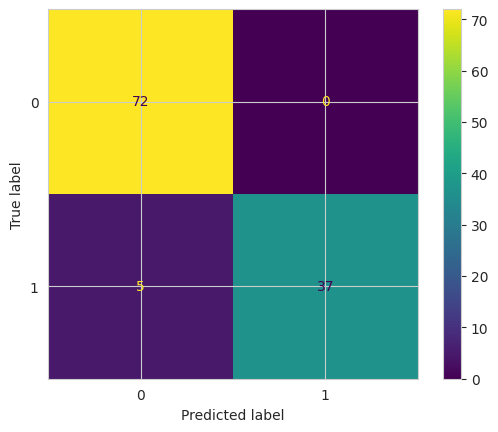

In [ ]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)
print('Subset accuracy:', lda.score(X_test, y_test))

# plot confusion matrix
model_pred = lda.predict(X_test)
print(confusion_matrix(y_test,model_pred))
print('\n')
print(classification_report(y_test,model_pred))
plot_confusion_matrix(lda, X_test, y_test)


In [ ]:
# Calculate all
model_pred = lda.predict(X_test)
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")

#k-fold
acc = k_evaluate(10, lda, x[feature_names[selected_features]], y)  # here k 10

precision :  1.0 
 recall : 0.935064935064935 
 f1_score : 0.9664429530201343


for fold: 2, accuracy is: 0.9543365455893255
for fold: 3, accuracy is: 0.952548036758563
for fold: 4, accuracy is: 0.9525632817886339
for fold: 5, accuracy is: 0.9472752678155567
for fold: 6, accuracy is: 0.9490481522956328
for fold: 7, accuracy is: 0.9491117133393555
for fold: 8, accuracy is: 0.9543231611893583
for fold: 9, accuracy is: 0.9543375220458553
for fold: 10, accuracy is: 0.9578320802005011
Best fit
10 gives accuracy of 0.9578320802005011


### Decision Tree

Subset accuracy: 0.9473684210526315
[[69  3]
 [ 3 39]]


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        72
           1       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



/home/shadowdude/dude/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



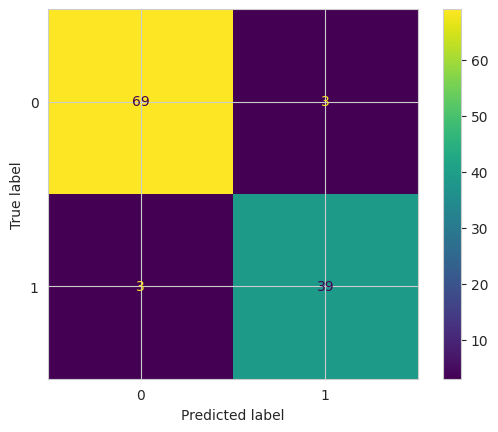

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)

# X_train = sc.fit_transform(X_train[:, selected_features])
# X_test = sc.transform(X_test[:, selected_features])
dt.fit(X_train, y_train)
print('Subset accuracy:', dt.score(X_test, y_test))

# plot confusion matrix
model_pred = dt.predict(X_test)
print(confusion_matrix(y_test,model_pred))
print('\n')
print(classification_report(y_test,model_pred))
plot_confusion_matrix(dt, X_test, y_test)


In [ ]:
# Calculate all
model_pred = dt.predict(X_test)
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")

#k-fold
acc = k_evaluate(10,dt, x[feature_names[selected_features]], y)  # here k 10

precision :  0.9583333333333334 
 recall : 0.9583333333333334 
 f1_score : 0.9583333333333334


for fold: 2, accuracy is: 0.9262107734124042
for fold: 3, accuracy is: 0.9139144156688017
for fold: 4, accuracy is: 0.9420122131389737
for fold: 5, accuracy is: 0.9262536873156343
for fold: 6, accuracy is: 0.9403135498320269
for fold: 7, accuracy is: 0.9315180453391835
for fold: 8, accuracy is: 0.94552034428795
for fold: 9, accuracy is: 0.9297288359788359
for fold: 10, accuracy is: 0.9350250626566415
Best fit
8 gives accuracy of 0.94552034428795


# Comparison

See the Breast Cancer Report card.

<a name=HGJ></a>
# Hybrid GWO with JAYA

In [ ]:
# import os
# os.chdir("/content/drive/MyDrive/Adv Machine Learning")
# os.listdir()

In [ ]:
# %cd 'Wrapper-Feature-Selection-Toolbox-Python-main'

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from FS.GWOJA import jfs   # change this to switch algorithm

In [ ]:

# grab our features
# y = data['diagnosis']
x = data.drop(['diagnosis'], axis= 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape:  (455, 30)
y_train shape:  (455,)
x_text:  (114, 30)
y_test:  (114,)


In [ ]:
# parameter
k    = 5     # k-value in KNN
N    = 10    # number of chromosomes
T    = 100   # maximum number of generations
CR   = 0.8
MR   = 0.01
fold = {'xt':x_train, 'yt':y_train, 'xv':x_test, 'yv':y_test}
x = x.to_numpy()
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'CR':CR, 'MR':MR}


In [ ]:
# y = y.values
print(type(x))

print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
fmdl = jfs(x, y, opts)
sf   = fmdl['sf']

Iteration: 1
Best (GWO): 0.03973684210526316
Iteration: 2
Best (GWOJA): 0.03840350877192983
Iteration: 3
Best (GWOJA): 0.02070175438596497
Iteration: 4
Best (GWOJA): 0.02070175438596497
Iteration: 5
Best (GWOJA): 0.02070175438596497
Iteration: 6
Best (GWOJA): 0.02070175438596497
Iteration: 7
Best (GWOJA): 0.02070175438596497
Iteration: 8
Best (GWOJA): 0.02070175438596497
Iteration: 9
Best (GWOJA): 0.02070175438596497
Iteration: 10
Best (GWOJA): 0.02070175438596497
Iteration: 11
Best (GWOJA): 0.02070175438596497
Iteration: 12
Best (GWOJA): 0.02070175438596497
Iteration: 13
Best (GWOJA): 0.012350877192982487
Iteration: 14
Best (GWOJA): 0.012350877192982487
Iteration: 15
Best (GWOJA): 0.012350877192982487
Iteration: 16
Best (GWOJA): 0.01168421052631582
Iteration: 17
Best (GWOJA): 0.01168421052631582
Iteration: 18
Best (GWOJA): 0.01168421052631582
Iteration: 19
Best (GWOJA): 0.01168421052631582
Iteration: 20
Best (GWOJA): 0.01168421052631582
Iteration: 21
Best (GWOJA): 0.01168421052631582


In [ ]:
# model with selected features
num_train = np.size(x_train, 0)
num_valid = np.size(x_test, 0)
x_train   = x_train[:, sf]
y_train   = y_train.reshape(num_train)  # Solve bug
x_valid   = x_test[:, sf]
y_valid   = y_test.reshape(num_valid)  # Solve bug

<AxesSubplot: >

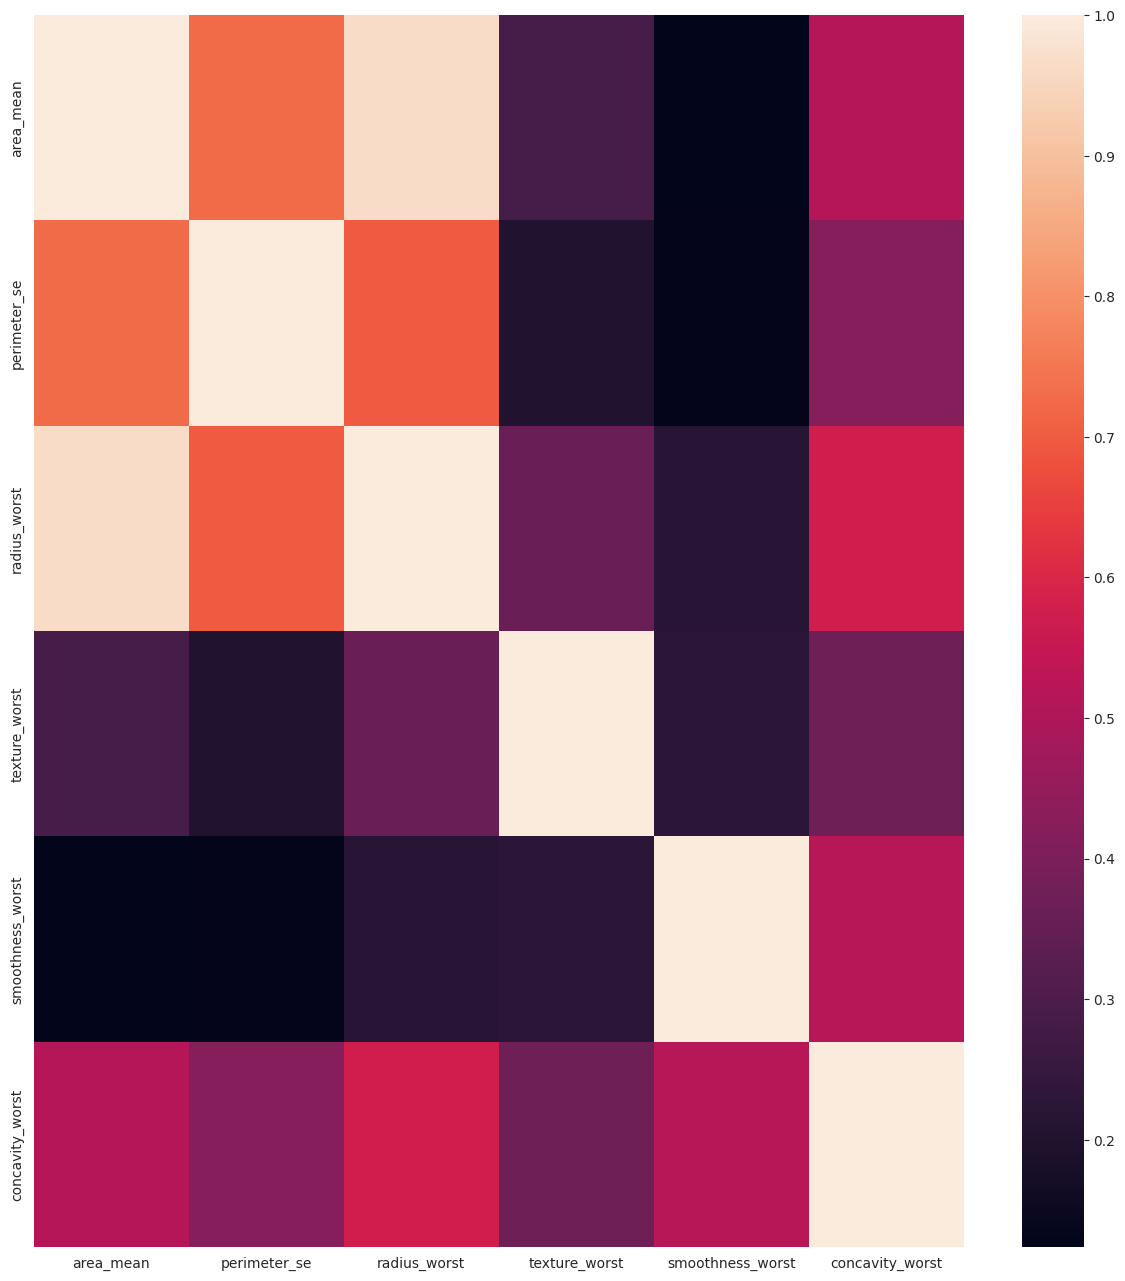

In [ ]:
f = fmdl['sf']   ## its 11
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))
cor = data[features].corr()
plt.figure(figsize=(15,16))
sns.heatmap(cor)

In [ ]:
len(features)

6

<a name=HC></a>
## Classification

### SVM

In [ ]:
# Model
model = SVC()
model.fit(x_train,y_train)
model_pred = model.predict(x_valid)

[[71  1]
 [ 2 40]]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



/home/shadowdude/dude/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



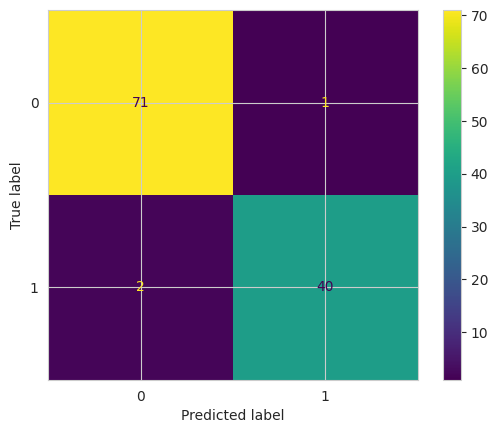

In [ ]:
print(confusion_matrix(y_valid,model_pred))
print('\n')
print(classification_report(y_valid,model_pred))
plot_confusion_matrix(model, x_valid, y_valid)

In [ ]:
# ROC curve
# plot_roc_curve(model, x_valid, y_valid)

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

precision :  0.9861111111111112 
 recall : 0.9726027397260274 
 f1_score : 0.9793103448275863


In [ ]:
#Kfold
acc = k_evaluate(10,model, x[:, sf], y)  # here k 10

for fold: 2, accuracy is: 0.8875092661230541
for fold: 3, accuracy is: 0.8804696927503946
for fold: 4, accuracy is: 0.8928149315473259
for fold: 5, accuracy is: 0.8857165036485017
for fold: 6, accuracy is: 0.8769130272489735
for fold: 7, accuracy is: 0.8788015657934356
for fold: 8, accuracy is: 0.883949530516432
for fold: 9, accuracy is: 0.8840388007054673
for fold: 10, accuracy is: 0.8855576441102757
Best fit
4 gives accuracy of 0.8928149315473259


### Decision Tree

[[67  5]
 [ 2 40]]


              precision    recall  f1-score   support

           0       0.97      0.93      0.95        72
           1       0.89      0.95      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



/home/shadowdude/dude/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



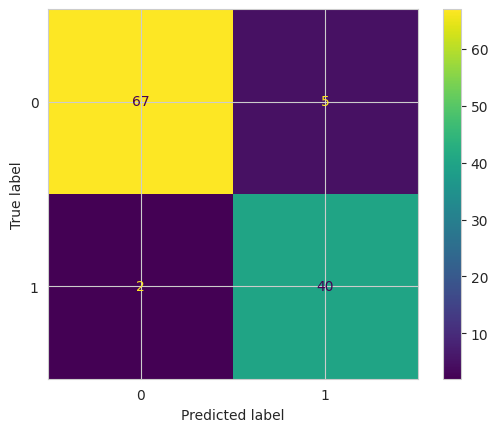

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_valid)

print(confusion_matrix(y_valid,dt_pred))
print('\n')
print(classification_report(y_valid,dt_pred))
plot_confusion_matrix(dt, x_valid, y_valid)

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

precision :  0.9305555555555556 
 recall : 0.9710144927536232 
 f1_score : 0.9503546099290779


In [ ]:
#Kfold
acc = k_evaluate(10,dt, x[:, sf], y)  # here k 10

for fold: 2, accuracy is: 0.9332592043489004
for fold: 3, accuracy is: 0.922686345493363
for fold: 4, accuracy is: 0.9367182113660987
for fold: 5, accuracy is: 0.9385033379909953
for fold: 6, accuracy is: 0.9419932810750279
for fold: 7, accuracy is: 0.9420140233148363
for fold: 8, accuracy is: 0.9402386541471048
for fold: 9, accuracy is: 0.9437555114638447
for fold: 10, accuracy is: 0.9402255639097744
Best fit
9 gives accuracy of 0.9437555114638447


### LDA

[[72  0]
 [ 5 37]]


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



/home/shadowdude/dude/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



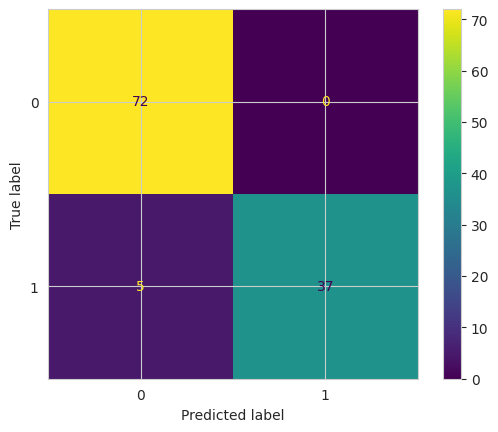

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_valid)

print(confusion_matrix(y_valid,lda_pred))
print('\n')
print(classification_report(y_valid,lda_pred))
plot_confusion_matrix(lda, x_valid, y_valid)

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, lda_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

precision :  1.0 
 recall : 0.935064935064935 
 f1_score : 0.9664429530201343


In [ ]:
#Kfold
acc = k_evaluate(10,lda, x[:, sf], y)  # here k 10

for fold: 2, accuracy is: 0.9455584383493947
for fold: 3, accuracy is: 0.9508029332590736
for fold: 4, accuracy is: 0.9525879050526938
for fold: 5, accuracy is: 0.9525694767893185
for fold: 6, accuracy is: 0.9508212019410228
for fold: 7, accuracy is: 0.9508753817696906
for fold: 8, accuracy is: 0.9525870500782473
for fold: 9, accuracy is: 0.9543650793650793
for fold: 10, accuracy is: 0.9507832080200501
Best fit
9 gives accuracy of 0.9543650793650793


# Great Job